# **Conversion analysis on Web Design**

For this project, we will be analyzing the results of an A/B test run by an e-commerce website. the final goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision

#Import data and data cleaning


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()


Saving sample_ab_data.csv to sample_ab_data.csv


In [61]:
df = pd.read_csv('sample_ab_data.csv')
print(df.head(10))

   user_id timestamp      group landing_page  converted
0   851104   11:48.6    control     old_page          0
1   804228   01:45.2    control     old_page          0
2   661590   55:06.2  treatment     new_page          1
3   853541   28:03.1  treatment     new_page          1
4   864975   52:26.2    control     old_page          1
5   936923   20:49.1    control     old_page          0
6   679687   26:46.9  treatment     new_page          1
7   719014   48:29.5    control     old_page          0
8   817355   58:09.0  treatment     new_page          1
9   839785   11:06.6  treatment     new_page          1


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [63]:
((df.group == 'treatment') & (df.landing_page == 'old_page')).sum()
#It does this by creating a boolean Series (True/False for each row),
#then .sum() adds up the True values (which count as 1), giving the total number of matching rows.

np.int64(1965)

In [64]:
((df.group == 'control')&(df.landing_page== 'new_page')).sum()


np.int64(1928)

In [66]:
df['misaligned'] = ((df.group =='treatment') & (df.landing_page == 'old_page')) | ((df.group =='control')&(df.landing_page=='new_page'))
df = df[~df['misaligned']]
#filter out mismatched group-page pairs
# ~ invert boolean conditions for filtering; df[...]Filters the DataFrame, keeping only rows where misaligned is False

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
 5   misaligned    290585 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 13.6+ MB


In [13]:
df.user_id.nunique()

290584

In [14]:
df['user_id'].value_counts().sort_values(ascending=False).head()

,count
user_id,
822618,2
904418,2
879483,2
888039,2
737298,2


# make assumption

In [42]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,1
2893,773192,55:59.6,treatment,new_page,0


if a user appears multiple times, we assume their lastest interaction reflects their final decision, so we keep the row with most recent timestamp.

In [68]:
df.drop(1899,axis=0,inplace=True)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   misaligned    290584 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 13.6+ MB


In [17]:
df[['user_id','group']].groupby('group').count()

,user_id
group,
control,147202
treatment,147275


In [44]:
df[['user_id','group','converted']].groupby('group').agg({'user_id':'count','converted':'mean'})
#conversion rate in each group

,user_id,converted
group,,
control,147202,0.120467
treatment,147275,0.125378


In [45]:
ab=df[['user_id','group','converted']].groupby('group').agg({'user_id':'count','converted':'sum'})
ab['conversion %'] = ab ['converted']/ ab['user_id']
ab['conversion %'] = ab['conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%')
ab



,user_id,converted,conversion %
group,,,
control,147202,17733,12.0%
treatment,147275,18465,12.5%


# Analyze results
let's assume that new page does not have higher conversion rate than the old page at 5% Type I eorre. so the hypothesis would be:
Null: P new- P old <= 0 ;Pnew <= Pold
Alternative: P new - P old > 0

In [46]:
convert_old = df[df.group == 'control'].converted.sum() #total number of conversion from control group
convert_new = df[df.group =='treatment'].converted.sum()
n_old = len(df[df.group == 'control'].converted) #total number of users who were shown the control group
n_new = len(df[df.group == 'treatment'].converted)
convert_old,convert_new,n_old,n_new

(np.int64(17733), np.int64(18465), 147202, 147275)

In [47]:
conversion_dic = {'Views':{'Control':n_old,'Test':n_new}, 'Converts':{'Control':convert_old,'Test':convert_new}}
conversion_table = pd.DataFrame(conversion_dic)
conversion_table['Conversion %']= conversion_table['Converts']/ conversion_table['Views']
conversion_table['Conversion %']= conversion_table['Conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%') #convert to percentage form
conversion_table

,Views,Converts,Conversion %
Control,147202,17733,12.0%
Test,147275,18465,12.5%


# Z-test
We use a z-test because the sample size is larger than 30, so by the Central Limit Theorem, the binomial distribution can be approximated by a normal distribution.

In [48]:
def z_test(p1,p0,n1,n0):
    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0) #combined conversion rates
    return delta / np.sqrt(p*(1-p) * (1/n1+1/n0))

In [49]:
p1 = convert_new/ n_new
p0 = convert_old/ n_old
n1 = n_new
n0 = n_old

In [14]:
z_value = z_test(p1,p0,n1,n0)
z_value
# high, suggesting strong difference between groups

np.float64(4.062695459865415)

In [15]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)
p_value

np.float64(2.4254649465982325e-05)

p_value < 0.05, so we can reject null hypothesis and accept alternative hypothesis that Pnew - Pold>0, the new page has higher conversion rate than the old page

**Z_test in Statsmodels**

In [16]:
import statsmodels.api as sm

In [17]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative = 'larger')
z_score, p_value
 #larger- if treatment>control(one_tailed test);
 #two_sided, when you don't know or care which group is better,just want to check if there's any difference
 #smaller- if the first group has a lower conversion rate than the second

(np.float64(4.062695459865415), np.float64(2.4254649465946946e-05))

smaller:H₀: p₁ ≥ p₀ H₁: p₁ < p₀ / Pnew-Pold>=0 Pnew-Pold<0
checking for negative impact from a change.
You launched a new feature and worry it might hurt conversion.
You want to test if the new version performs worse than the old one.
larger: if the new version improves performance — you're not interested if it's worse.


EDA


In [9]:
df['minutes'] = df['timestamp'].str.split(':').str[0].astype(int)

In [21]:
df.head()

,user_id,timestamp,group,landing_page,converted,minutes
0,851104,11:48.6,control,old_page,0,11
1,804228,01:45.2,control,old_page,0,1
2,661590,55:06.2,treatment,new_page,1,55
3,853541,28:03.1,treatment,new_page,1,28
4,864975,52:26.2,control,old_page,1,52


In [12]:
grouped = df.groupby(['minutes','group'])['converted'].mean().reset_index()

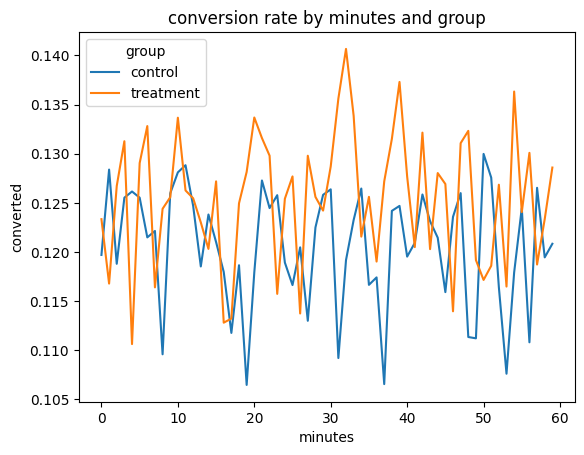

In [32]:
sns.lineplot(data=grouped, x='minutes',y='converted',hue='group')
plt.title('conversion rate by minutes and group')
plt.show()

**t_test**

In [50]:
def t_test(p1,p0,n1,n0):
    delta = p1-p0
    se = np.sqrt(p1*(1-p1)/n1 + p0*(1-p0)/n0)
    return delta/se

In [51]:
p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [52]:
t_value = t_test(p1,p0,n1,n0)
t_value

np.float64(4.057954247258046)

In [53]:
from scipy.stats import t
df = min(n1,n0) -1
p_value = (2 * (1-t.cdf(abs(t_value),df)))/2
p_value

np.float64(2.4764989539960425e-05)

# t_test in stasmodels
we do one_tailed in this project
the package is two-tailed, thus we need to modify the code to one tailed

In [70]:
from scipy.stats import ttest_ind

group_new = df[df['group'] == 'treatment']['converted']
group_old = df[df['group'] == 'control']['converted']

t_stat, p_value = ttest_ind(group_new,group_old, equal_var=False)

if t_stat > 0:
  p_value = p_value/2
else:
  p_value = 1 - (p_value /2)

p_value

np.float64(2.2758199180985844e-05)